### Dataset Schema

The dataset will include the following features:

#### Patient Demographics
- **Age**: Patient's age (numeric).
- **Gender**: Male or Female (categorical).
- **Income_Level**: Low, Medium, or High (categorical).

#### Behavioral Data
- **Missed_Appointments**: Number of missed medical appointments in the past year (numeric).
- **Refill_Gaps**: Average number of days between prescription refills (numeric).

#### Clinical Data
- **Comorbidities**: Number of comorbid conditions (numeric).
- **Side_Effects_Severity**: Severity of side effects (Low, Medium, High) (categorical).
- **Polypharmacy**: Number of medications the patient is taking (numeric).

#### Psychological and Social Factors
- **Health_Literacy**: Low, Medium, or High (categorical).
- **Mental_Health_Status**: Depression, Anxiety, None (categorical).
- **Social_Support**: Low, Medium, or High (categorical).

#### System-Related Factors
- **Medication_Cost**: Monthly cost of medication in USD (numeric).
- **Provider_Communication**: Quality of communication with healthcare provider (Low, Medium, High) (categorical).

#### Target Variable
- **Adherence**: Binary variable indicating whether the patient adhered to the treatment plan (1 = Adherent, 0 = Non-Adherent).

In [1]:
import pandas as pd
import numpy as np
import random

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 1000

# Generate synthetic data
data = {
    "Age": np.random.randint(18, 80, n_samples),
    "Gender": np.random.choice(["Male", "Female"], n_samples),
    "Income_Level": np.random.choice(["Low", "Medium", "High"], n_samples, p=[0.3, 0.5, 0.2]),
    "Missed_Appointments": np.random.randint(0, 10, n_samples),
    "Refill_Gaps": np.random.randint(0, 30, n_samples),
    "Comorbidities": np.random.randint(0, 5, n_samples),
    "Side_Effects_Severity": np.random.choice(["Low", "Medium", "High"], n_samples, p=[0.5, 0.3, 0.2]),
    "Polypharmacy": np.random.randint(1, 10, n_samples),
    "Health_Literacy": np.random.choice(["Low", "Medium", "High"], n_samples, p=[0.2, 0.5, 0.3]),
    "Mental_Health_Status": np.random.choice(["None", "Depression", "Anxiety"], n_samples, p=[0.6, 0.25, 0.15]),
    "Social_Support": np.random.choice(["Low", "Medium", "High"], n_samples, p=[0.3, 0.5, 0.2]),
    "Medication_Cost": np.random.randint(10, 500, n_samples),
    "Provider_Communication": np.random.choice(["Low", "Medium", "High"], n_samples, p=[0.2, 0.5, 0.3]),
}

# Generate target variable (Adherence) based on some rules
def generate_adherence(row):
    # Higher adherence likelihood for patients with:
    # - High income, good provider communication, low refill gaps, and high social support
    adherence_score = (
        (row["Income_Level"] == "High") * 2 +
        (row["Provider_Communication"] == "High") * 2 +
        (row["Social_Support"] == "High") * 1.5 +
        (row["Refill_Gaps"] < 10) * 1.5 +
        (row["Side_Effects_Severity"] == "Low") * 1.5 +
        (row["Health_Literacy"] == "High") * 1.5
    )
    # Random noise
    adherence_score += np.random.normal(0, 1)
    return 1 if adherence_score > 3 else 0

# Convert to DataFrame
df = pd.DataFrame(data)

# Apply adherence generation function
df["Adherence"] = df.apply(generate_adherence, axis=1)

# Save to CSV
df.to_csv("synthetic_treatment_adherence_data.csv", index=False)

# Print sample data
print(df.head())

   Age  Gender Income_Level  Missed_Appointments  Refill_Gaps  Comorbidities  \
0   56    Male          Low                    3           28              4   
1   69    Male       Medium                    7           21              2   
2   46  Female          Low                    6           11              2   
3   32    Male          Low                    4            8              0   
4   60    Male       Medium                    9            4              4   

  Side_Effects_Severity  Polypharmacy Health_Literacy Mental_Health_Status  \
0                Medium             6          Medium                 None   
1                Medium             4            High                 None   
2                Medium             5          Medium              Anxiety   
3                  High             1            High                 None   
4                   Low             7          Medium                 None   

  Social_Support  Medication_Cost Provider_Communi

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)

### Step 1: Detailed Exploratory Data Analysis (EDA)
#### Key Steps in EDA:
* Load and Inspect the Dataset
* Check for Missing Values
* Analyze Data Types
* Summary Statistics
* Univariate Analysis
* Bivariate Analysis
* Correlation Analysis
* Outlier Detection
* Feature Distributions
* Target Variable Analysis

In [7]:
# -------------------------------------------------
# Step 1: Load the dataset and perform initial EDA
# -------------------------------------------------
# Load the dataset
data = pd.read_csv('synthetic_treatment_adherence_data.csv')

# Display the first few rows
print("First 5 rows of the dataset:")
print(data.head())

# Display dataset information
print("\nDataset Info:")
print(data.info())

print("\n----- Summary Statistics -----")
print(df.describe())

# Check the shape of the dataset
print(f"\nDataset contains {data.shape[0]} rows and {data.shape[1]} columns.")

First 5 rows of the dataset:
   Age  Gender Income_Level  Missed_Appointments  Refill_Gaps  Comorbidities  \
0   56    Male          Low                    3           28              4   
1   69    Male       Medium                    7           21              2   
2   46  Female          Low                    6           11              2   
3   32    Male          Low                    4            8              0   
4   60    Male       Medium                    9            4              4   

  Side_Effects_Severity  Polypharmacy Health_Literacy Mental_Health_Status  \
0                Medium             6          Medium                  NaN   
1                Medium             4            High                  NaN   
2                Medium             5          Medium              Anxiety   
3                  High             1            High                  NaN   
4                   Low             7          Medium                  NaN   

  Social_Support  Med

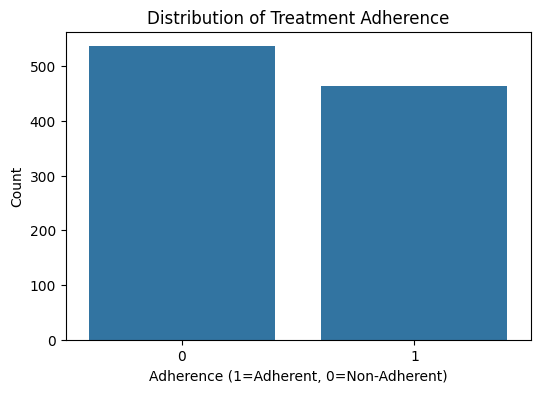

In [4]:
# Check the distribution of the target variable
plt.figure(figsize=(6,4))
sns.countplot(x="Adherence", data=df)
plt.title("Distribution of Treatment Adherence")
plt.xlabel("Adherence (1=Adherent, 0=Non-Adherent)")
plt.ylabel("Count")
plt.show()

In [8]:
# Check for missing values
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100

print("\nMissing Values:")
print(pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage}).sort_values(by='Percentage', ascending=False))


Missing Values:
                        Missing Values  Percentage
Mental_Health_Status               573        57.3
Age                                  0         0.0
Income_Level                         0         0.0
Missed_Appointments                  0         0.0
Refill_Gaps                          0         0.0
Gender                               0         0.0
Comorbidities                        0         0.0
Side_Effects_Severity                0         0.0
Polypharmacy                         0         0.0
Health_Literacy                      0         0.0
Social_Support                       0         0.0
Medication_Cost                      0         0.0
Provider_Communication               0         0.0
Adherence                            0         0.0


In [9]:
# Check data types
print("\nData Types:")
print(data.dtypes)

# Identify categorical and numerical columns
categorical_columns = data.select_dtypes(include=['object', 'category']).columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

print(f"\nCategorical Columns: {list(categorical_columns)}")
print(f"Numerical Columns: {list(numerical_columns)}")


Data Types:
Age                        int64
Gender                    object
Income_Level              object
Missed_Appointments        int64
Refill_Gaps                int64
Comorbidities              int64
Side_Effects_Severity     object
Polypharmacy               int64
Health_Literacy           object
Mental_Health_Status      object
Social_Support            object
Medication_Cost            int64
Provider_Communication    object
Adherence                  int64
dtype: object

Categorical Columns: ['Gender', 'Income_Level', 'Side_Effects_Severity', 'Health_Literacy', 'Mental_Health_Status', 'Social_Support', 'Provider_Communication']
Numerical Columns: ['Age', 'Missed_Appointments', 'Refill_Gaps', 'Comorbidities', 'Polypharmacy', 'Medication_Cost', 'Adherence']


In [10]:
# Summary statistics for numerical columns
print("\nSummary Statistics for Numerical Columns:")
print(data[numerical_columns].describe())

# Summary statistics for categorical columns
print("\nSummary Statistics for Categorical Columns:")
print(data[categorical_columns].describe())


Summary Statistics for Numerical Columns:
               Age  Missed_Appointments  Refill_Gaps  Comorbidities  \
count  1000.000000          1000.000000  1000.000000    1000.000000   
mean     49.857000             4.410000    14.961000       2.079000   
std      18.114267             2.844643     8.774307       1.398827   
min      18.000000             0.000000     0.000000       0.000000   
25%      35.000000             2.000000     7.000000       1.000000   
50%      50.000000             4.000000    15.000000       2.000000   
75%      66.000000             7.000000    23.000000       3.000000   
max      79.000000             9.000000    29.000000       4.000000   

       Polypharmacy  Medication_Cost    Adherence  
count   1000.000000      1000.000000  1000.000000  
mean       4.927000       256.449000     0.464000  
std        2.562858       144.849614     0.498952  
min        1.000000        10.000000     0.000000  
25%        3.000000       127.000000     0.000000  
50%  

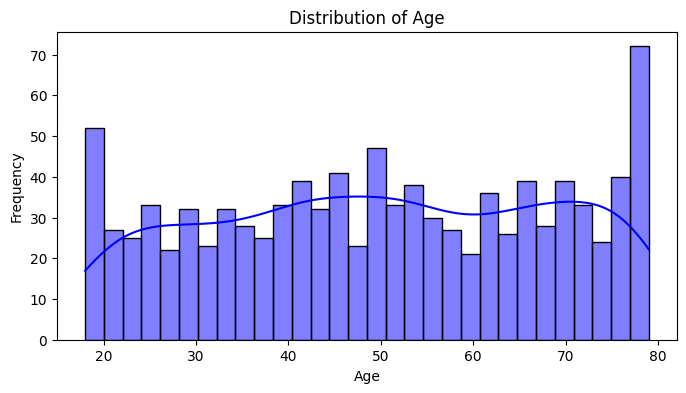

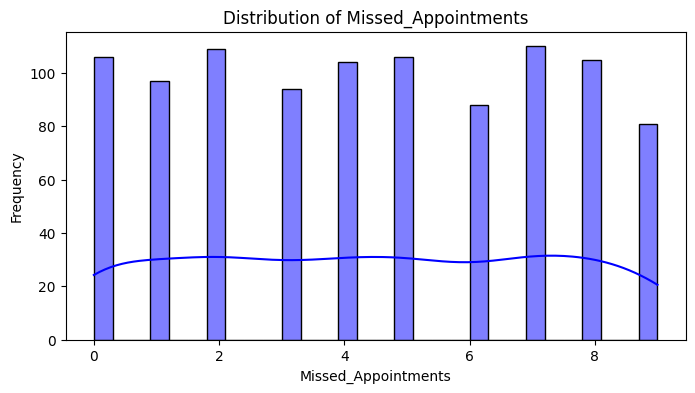

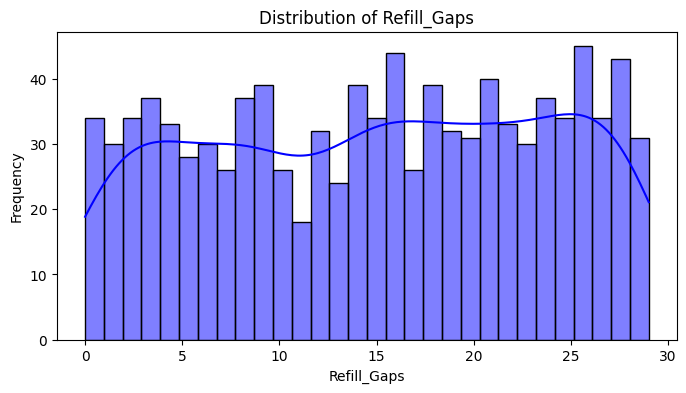

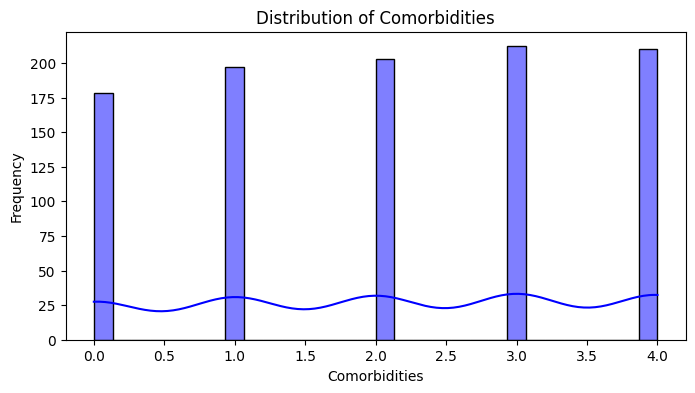

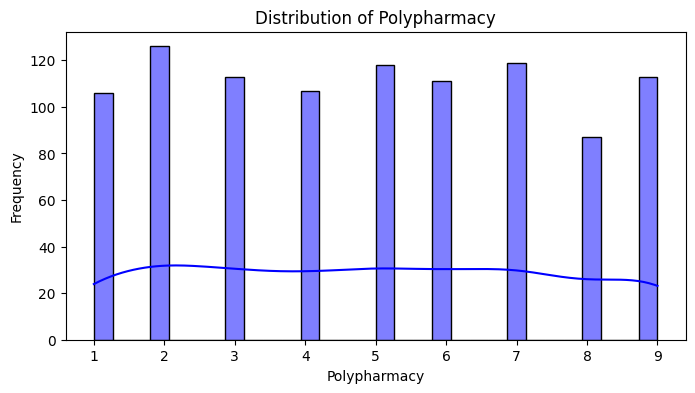

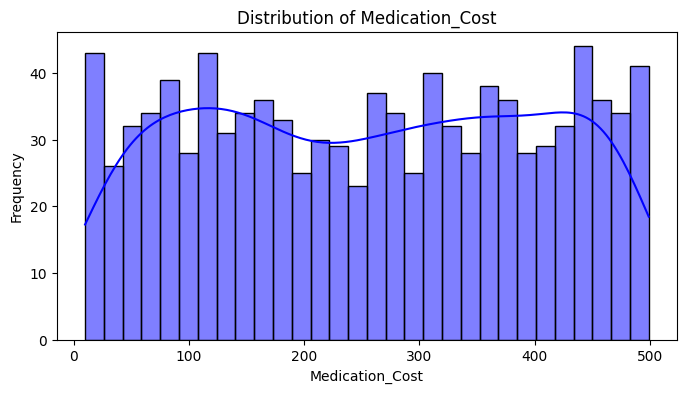

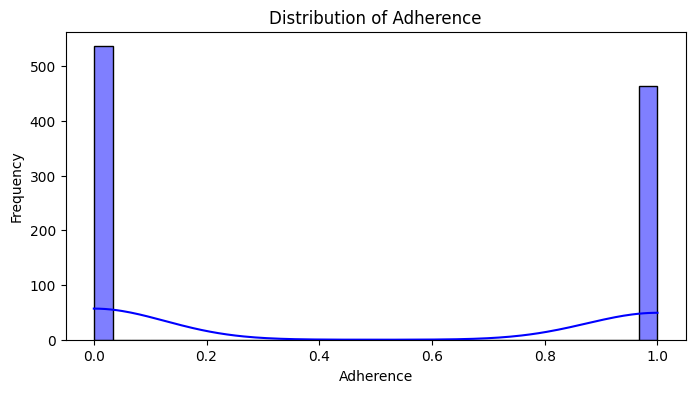

C:\Users\benjamin.trinh\AppData\Local\Temp\ipykernel_27900\1370065064.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data[col], palette='viridis')


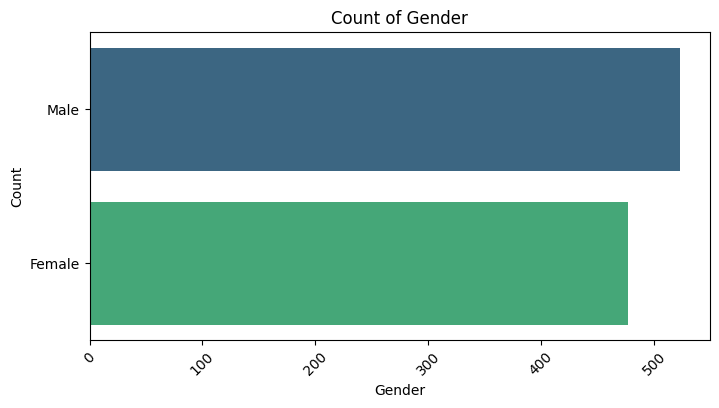

C:\Users\benjamin.trinh\AppData\Local\Temp\ipykernel_27900\1370065064.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data[col], palette='viridis')


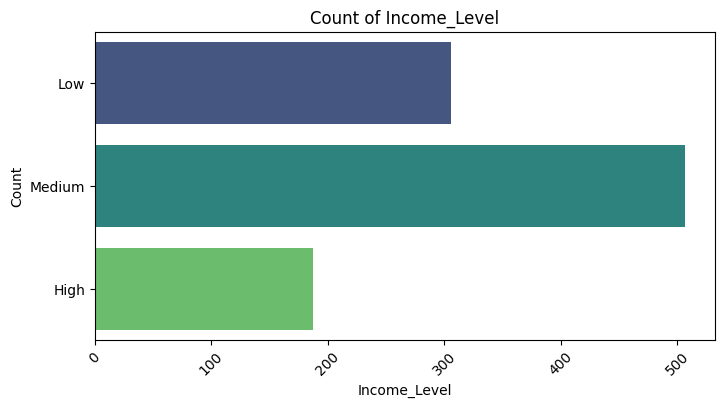

C:\Users\benjamin.trinh\AppData\Local\Temp\ipykernel_27900\1370065064.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data[col], palette='viridis')


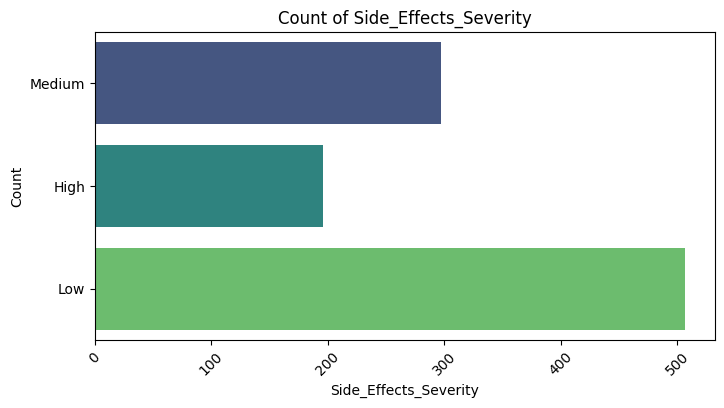

C:\Users\benjamin.trinh\AppData\Local\Temp\ipykernel_27900\1370065064.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data[col], palette='viridis')


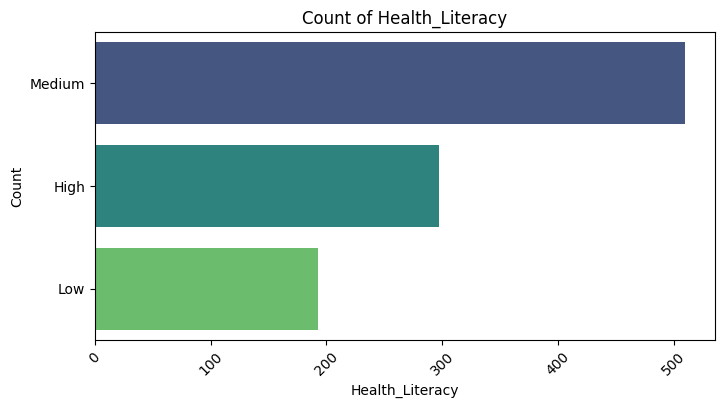

C:\Users\benjamin.trinh\AppData\Local\Temp\ipykernel_27900\1370065064.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data[col], palette='viridis')


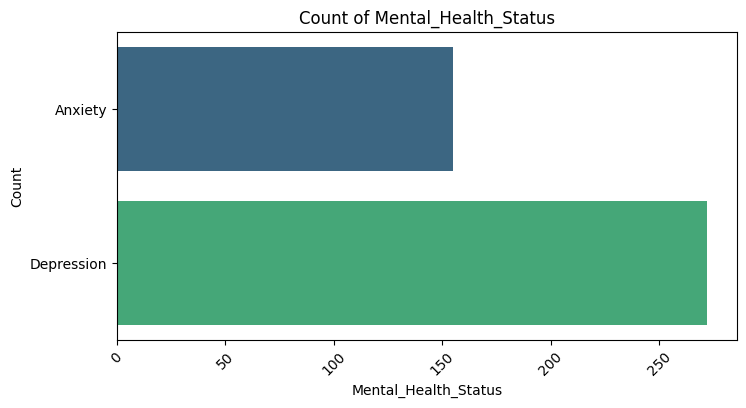

C:\Users\benjamin.trinh\AppData\Local\Temp\ipykernel_27900\1370065064.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data[col], palette='viridis')


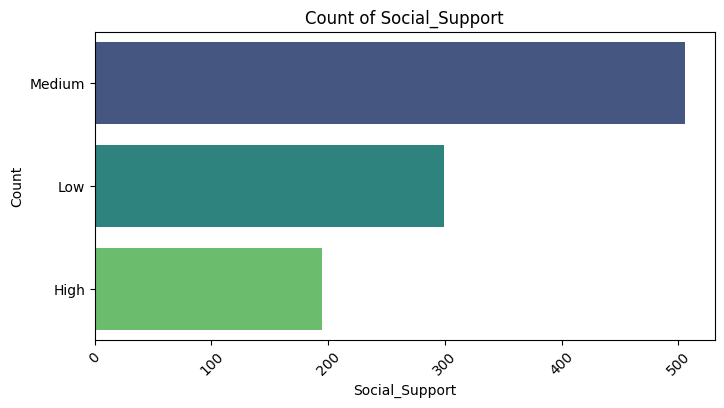

C:\Users\benjamin.trinh\AppData\Local\Temp\ipykernel_27900\1370065064.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data[col], palette='viridis')


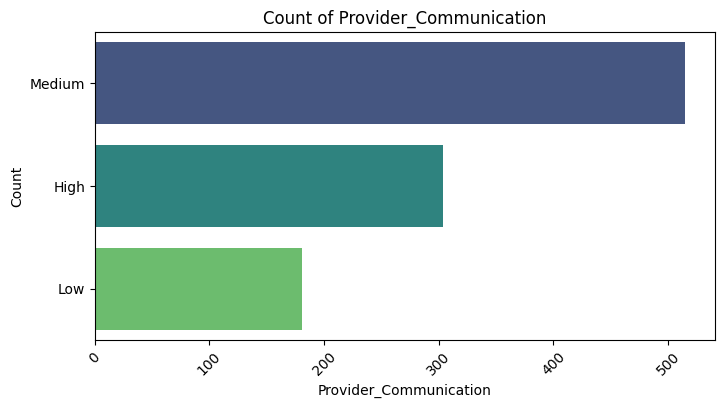

In [11]:
# Plot distributions for numerical columns
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Plot bar charts for categorical columns
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data[col], palette='viridis')
    plt.title(f'Count of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

C:\Users\benjamin.trinh\AppData\Local\Temp\ipykernel_27900\2314592641.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_variable, y=col, data=data, palette='viridis')


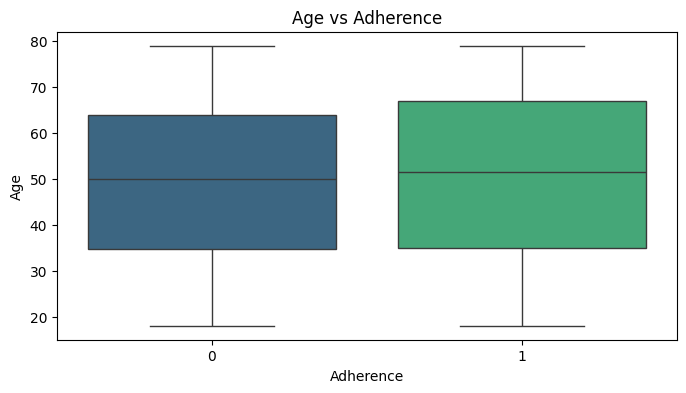

C:\Users\benjamin.trinh\AppData\Local\Temp\ipykernel_27900\2314592641.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_variable, y=col, data=data, palette='viridis')


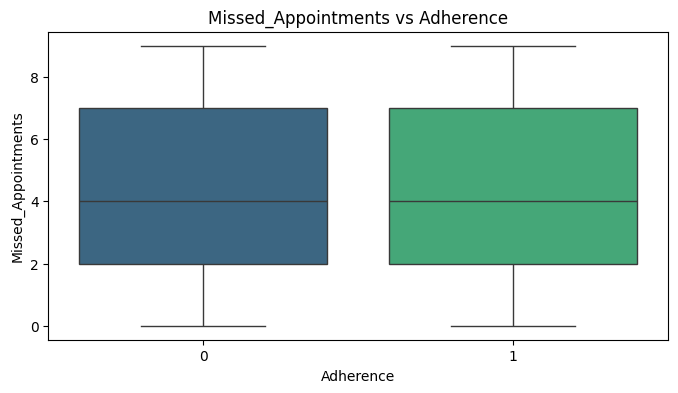

C:\Users\benjamin.trinh\AppData\Local\Temp\ipykernel_27900\2314592641.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_variable, y=col, data=data, palette='viridis')


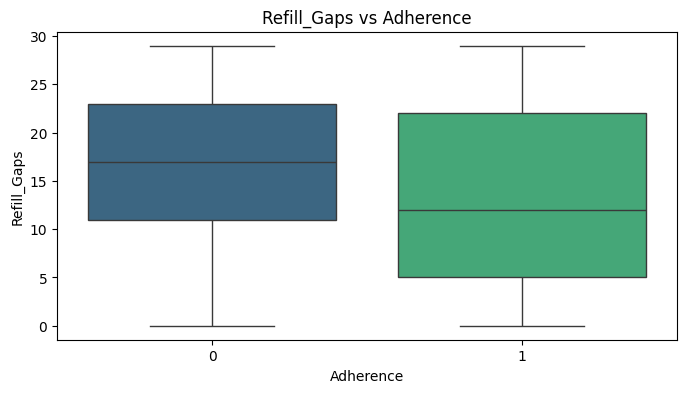

C:\Users\benjamin.trinh\AppData\Local\Temp\ipykernel_27900\2314592641.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_variable, y=col, data=data, palette='viridis')


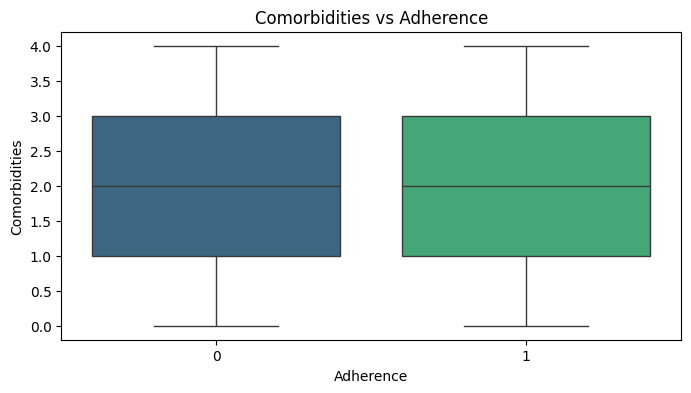

C:\Users\benjamin.trinh\AppData\Local\Temp\ipykernel_27900\2314592641.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_variable, y=col, data=data, palette='viridis')


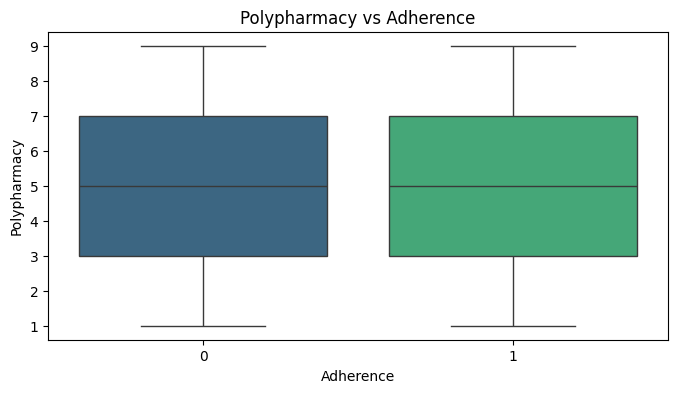

C:\Users\benjamin.trinh\AppData\Local\Temp\ipykernel_27900\2314592641.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_variable, y=col, data=data, palette='viridis')


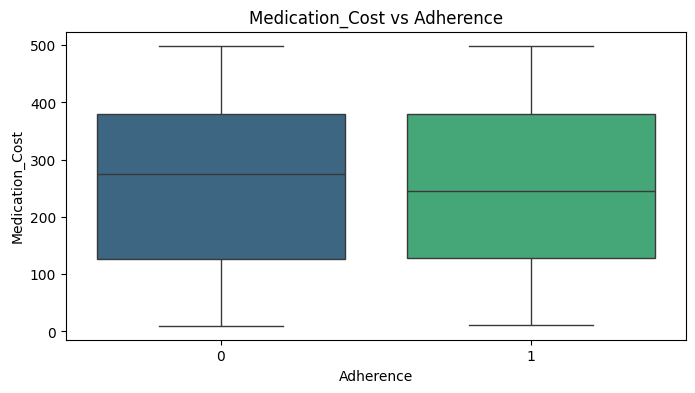

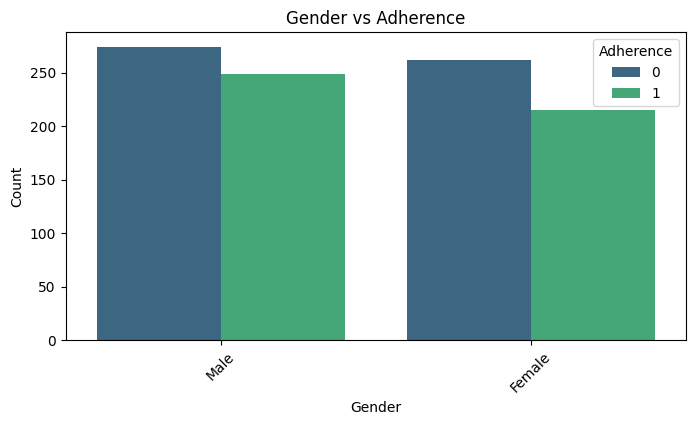

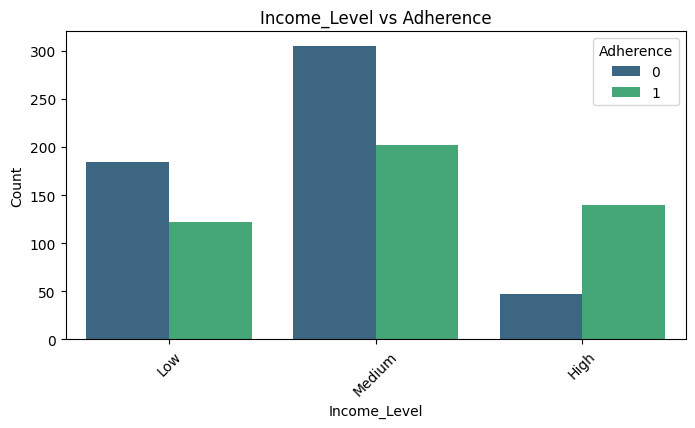

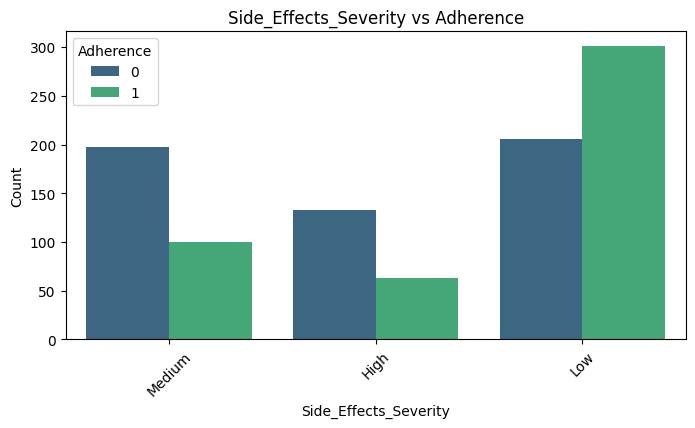

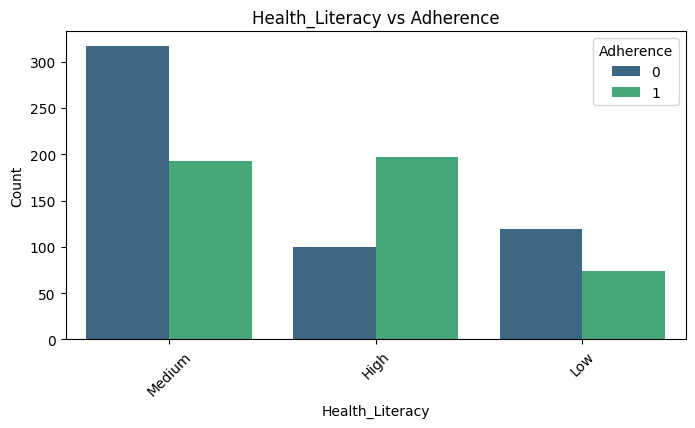

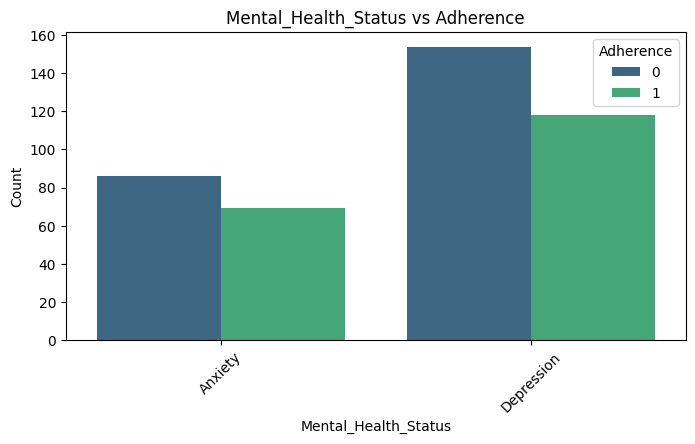

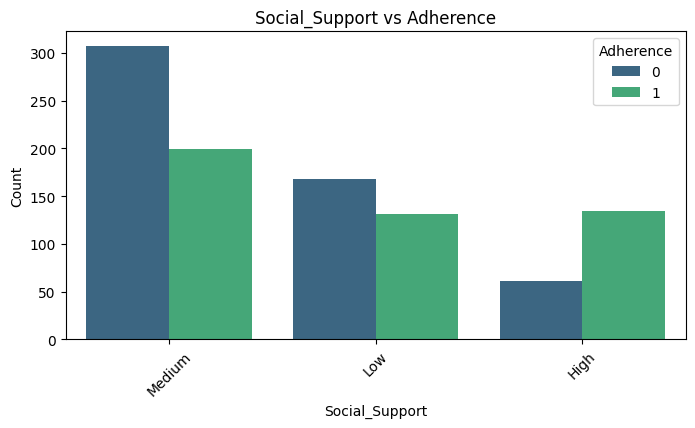

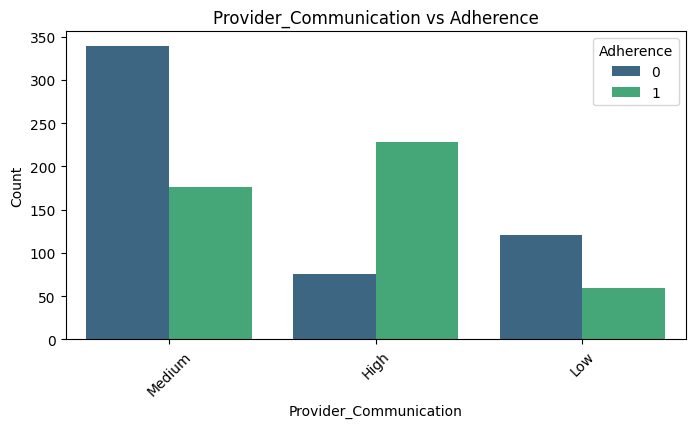

In [12]:
# Analyze relationships between numerical features and the target variable
target_variable = 'Adherence'  # Replace with your actual target column name

for col in numerical_columns:
    if col != target_variable:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=target_variable, y=col, data=data, palette='viridis')
        plt.title(f'{col} vs {target_variable}')
        plt.xlabel(target_variable)
        plt.ylabel(col)
        plt.show()

# Analyze relationships between categorical features and the target variable
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue=target_variable, data=data, palette='viridis')
    plt.title(f'{col} vs {target_variable}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

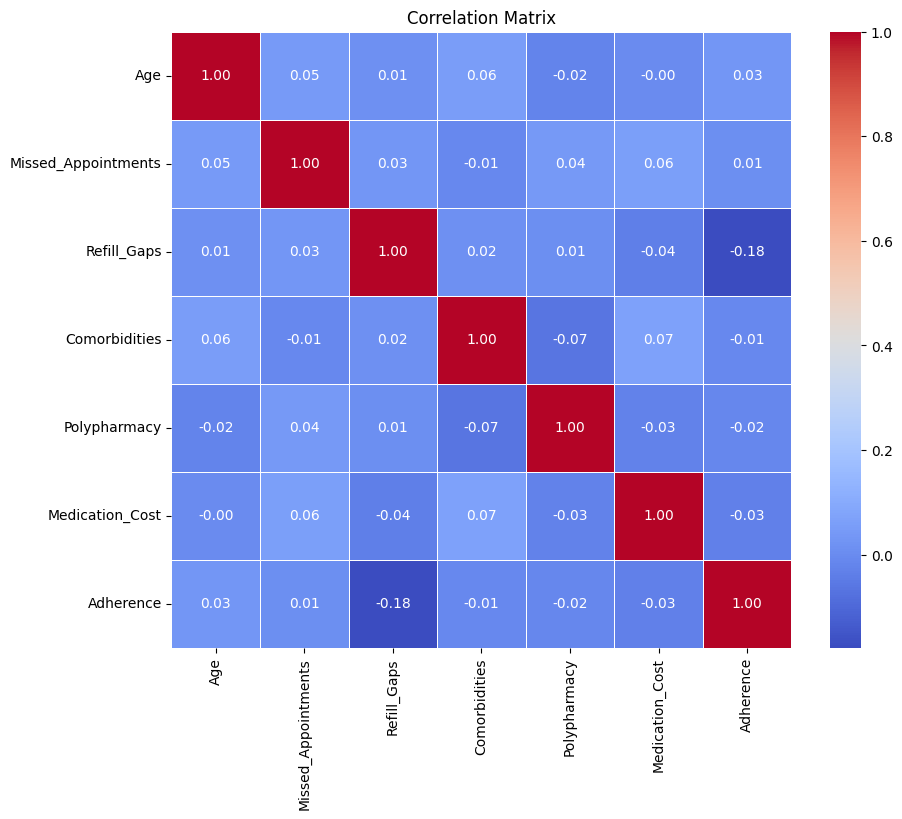


Correlation with Target Variable:
Adherence              1.000000
Age                    0.033043
Missed_Appointments    0.008999
Comorbidities         -0.008112
Polypharmacy          -0.015756
Medication_Cost       -0.031791
Refill_Gaps           -0.177407
Name: Adherence, dtype: float64


In [13]:
# Compute correlation matrix
correlation_matrix = data[numerical_columns].corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Correlation with the target variable
if target_variable in numerical_columns:
    target_corr = correlation_matrix[target_variable].sort_values(ascending=False)
    print("\nCorrelation with Target Variable:")
    print(target_corr)

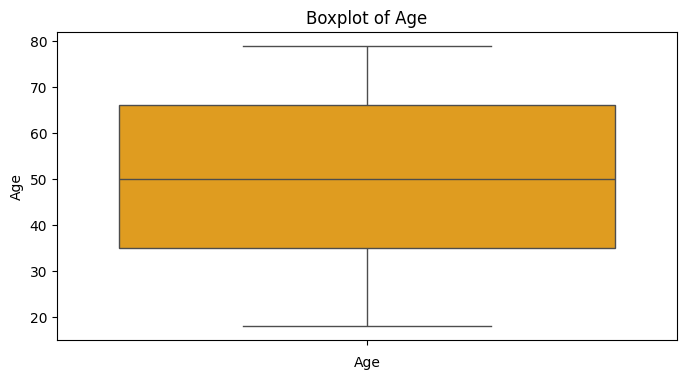

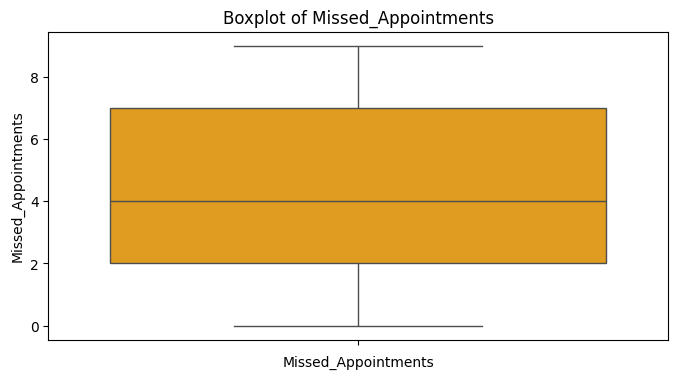

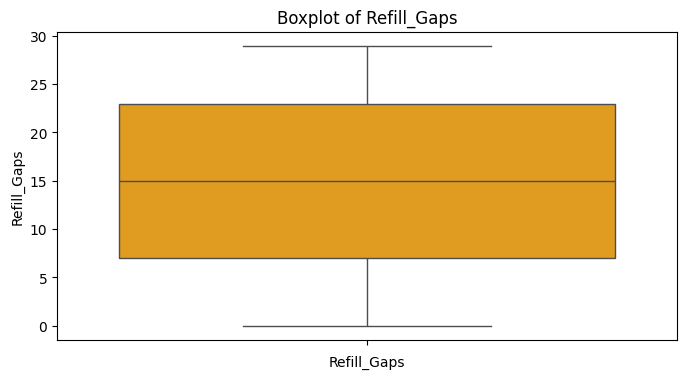

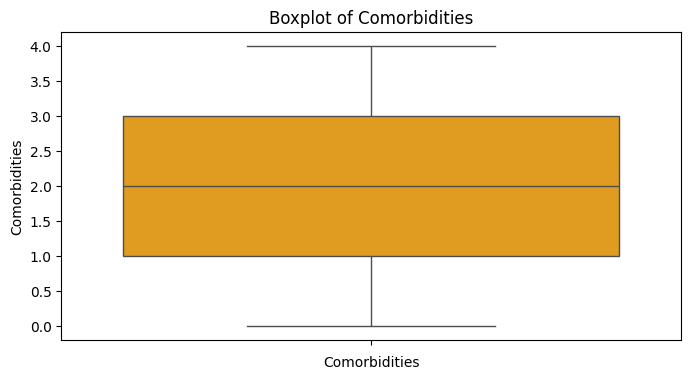

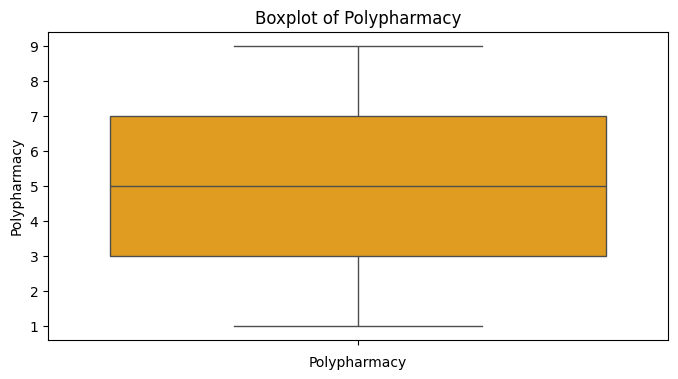

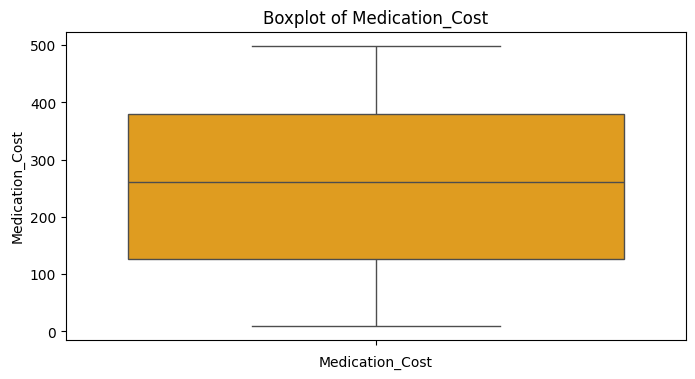

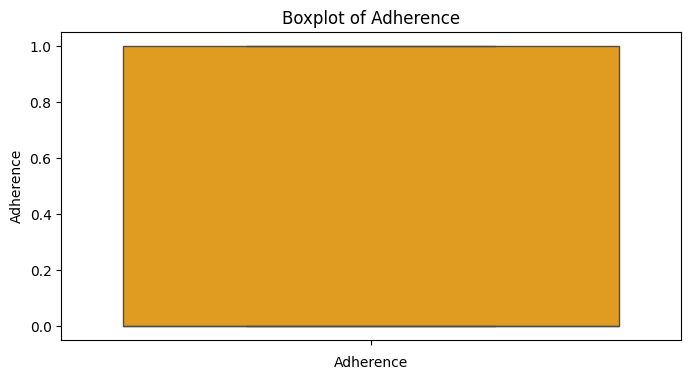

In [14]:
# Plot boxplots for numerical columns
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data[col], color='orange')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

In [ ]:
# Check for skewness and normality in numerical features.

from scipy.stats import skew, kurtosis

# Calculate skewness and kurtosis
for col in numerical_columns:
    skewness = skew(data[col].dropna())
    kurt = kurtosis(data[col].dropna())
    print(f"{col}: Skewness = {skewness:.2f}, Kurtosis = {kurt:.2f}")

Age: Skewness = -0.07, Kurtosis = -1.16
Missed_Appointments: Skewness = 0.01, Kurtosis = -1.22
Refill_Gaps: Skewness = -0.09, Kurtosis = -1.23
Comorbidities: Skewness = -0.07, Kurtosis = -1.27
Polypharmacy: Skewness = 0.05, Kurtosis = -1.20
Medication_Cost: Skewness = -0.01, Kurtosis = -1.26
Adherence: Skewness = 0.14, Kurtosis = -1.98


C:\Users\benjamin.trinh\AppData\Local\Temp\ipykernel_27900\3144908660.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data[target_variable], palette='viridis')


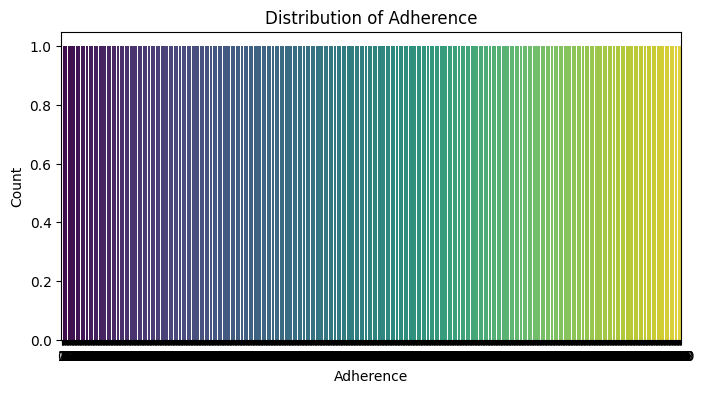

In [16]:
# Target variable analysis

# Plot the distribution of the target variable
plt.figure(figsize=(8, 4))
sns.countplot(data[target_variable], palette='viridis')
plt.title(f'Distribution of {target_variable}')
plt.xlabel(target_variable)
plt.ylabel('Count')
plt.show()

In [17]:
df = pd.read_csv("synthetic_treatment_adherence_data.csv")

# -------------------------------
# Step 2: Feature Engineering
# -------------------------------
# For this dataset, we need to convert categorical features into dummy/indicator variables.
# Identifying categorical columns:
categorical_cols = [
    "Gender", "Income_Level", "Side_Effects_Severity",
    "Health_Literacy", "Mental_Health_Status", "Social_Support", "Provider_Communication"
]

# Convert these categorical variables using one-hot encoding (drop_first to avoid dummy trap)
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Optional: Scale numeric variables if needed
numeric_cols = ["Age", "Missed_Appointments", "Refill_Gaps", "Comorbidities", "Polypharmacy", "Medication_Cost"]
scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

print("\n----- Columns after Encoding -----")
print(df_encoded.columns)


----- Columns after Encoding -----
Index(['Age', 'Missed_Appointments', 'Refill_Gaps', 'Comorbidities',
       'Polypharmacy', 'Medication_Cost', 'Adherence', 'Gender_Male',
       'Income_Level_Low', 'Income_Level_Medium', 'Side_Effects_Severity_Low',
       'Side_Effects_Severity_Medium', 'Health_Literacy_Low',
       'Health_Literacy_Medium', 'Mental_Health_Status_Depression',
       'Social_Support_Low', 'Social_Support_Medium',
       'Provider_Communication_Low', 'Provider_Communication_Medium'],
      dtype='object')


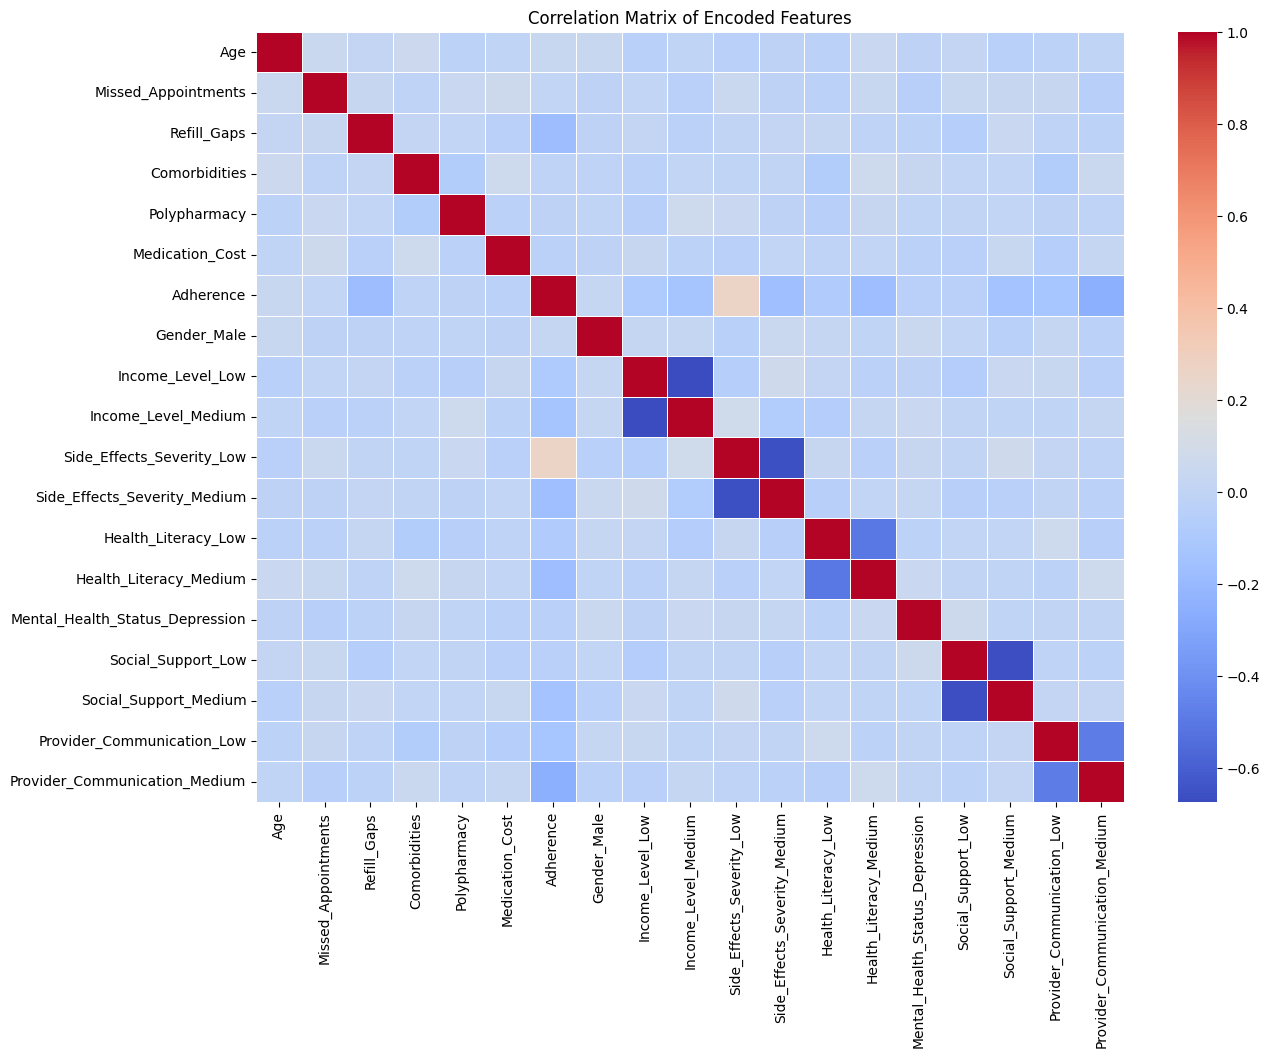


----- Feature Importances (Random Forest) -----
Refill_Gaps                      0.148319
Medication_Cost                  0.115034
Age                              0.106417
Polypharmacy                     0.075260
Missed_Appointments              0.074693
Provider_Communication_Medium    0.071205
Side_Effects_Severity_Low        0.059345
Comorbidities                    0.055256
Provider_Communication_Low       0.047775
Health_Literacy_Medium           0.039221
dtype: float64


In [18]:
# -------------------------------
# Step 3: Feature Selection (Exploratory)
# -------------------------------
# For an initial check, we can perform a correlation heatmap. Note that correlation is best suited for numeric data.
plt.figure(figsize=(14,10))
sns.heatmap(df_encoded.corr(), annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Encoded Features")
plt.show()

# We can also check feature importances using a simple Random Forest on the entire dataset.
X = df_encoded.drop("Adherence", axis=1)
y = df_encoded["Adherence"]

rf_temp = RandomForestClassifier(random_state=42)
rf_temp.fit(X, y)
importances = pd.Series(rf_temp.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n----- Feature Importances (Random Forest) -----")
print(importances.head(10))

In [8]:
# -------------------------------
# Step 4: Train-Test Split
# -------------------------------
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


===== Logistic Regression =====
Cross-validation Accuracy (Mean): 0.7900
Test Set Accuracy: 0.8150
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       106
           1       0.81      0.80      0.80        94

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200

ROC-AUC Score: 0.9016

===== Random Forest =====
Cross-validation Accuracy (Mean): 0.7312
Test Set Accuracy: 0.7600
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       106
           1       0.77      0.70      0.73        94

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.76      0.76      0.76       200

ROC-AUC Score: 0.8135

===== Gradient Boosting =====
Cross-validation Accuracy (Mean

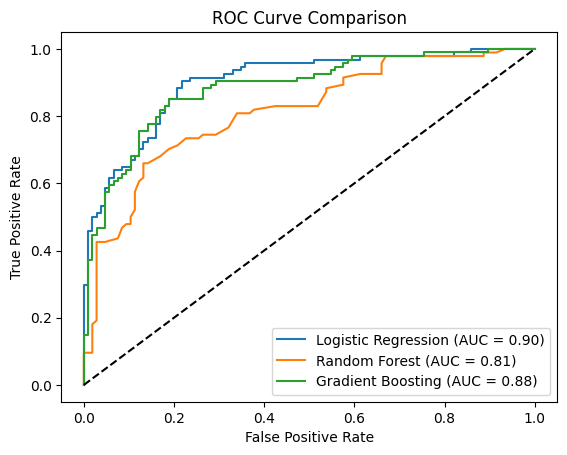

In [9]:
# -------------------------------
# Step 5: Model Training with Different Models
# -------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

cv_results = {}
test_results = {}

for name, model in models.items():
    # 5-fold cross-validation accuracy
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    cv_results[name] = cv_score.mean()

    # Train on the full training data
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    test_results[name] = acc
    print(f"\n===== {name} =====")
    print(f"Cross-validation Accuracy (Mean): {cv_score.mean():.4f}")
    print(f"Test Set Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, preds))

    # Compute ROC-AUC
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]
    else:
        # If model does not support predict_proba, use decision_function
        y_probs = model.decision_function(X_test)
    auc = roc_auc_score(y_test, y_probs)
    print(f"ROC-AUC Score: {auc:.4f}")

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

In [10]:
# -------------------------------
# Step 6: Model Comparison and Selection
# -------------------------------
results_df = pd.DataFrame({
    "Model": list(cv_results.keys()),
    "CV Accuracy": list(cv_results.values()),
    "Test Accuracy": list(test_results.values())
})
print("\n----- Model Comparison -----")
print(results_df.sort_values(by="Test Accuracy", ascending=False))

# Based on the CV and test accuracy metrics (and ROC-AUC scores printed above),
# you can select the optimal model. For example, if Random Forest yields the highest scores, you might pick Random Forest.


----- Model Comparison -----
                 Model  CV Accuracy  Test Accuracy
0  Logistic Regression      0.79000          0.815
2    Gradient Boosting      0.77875          0.800
1        Random Forest      0.73125          0.760
